### Maricopa Agricultural Center Season 4

### Citation for Input Trait Data

LeBauer, David et al. (2020), Data From: TERRA-REF, An open reference data set from high resolution genomics, phenomics, and imaging sensors, v6, Dryad, Dataset, https://doi.org/10.5061/dryad.4b8gtht99

#### Environmental weather data 
- Raw data downloaded from the MAC weather station [website](https://cals.arizona.edu/azmet/06.htm)
- Processed using the code from [`weather_data_cleaning.py`](/iplant/home/shared/genophenoenvo/scripts/weather_data_cleaning.py)
- Processed MAC Season 4 [weather data](https://de.cyverse.org/dl/d/6D959379-0442-41FE-8BEE-890866ACF037/mac_season_4_weather.csv)

Please email dlebauer@email.arizona.edu or ejcain@arizona.edu with any questions or comments, or create an issue in this [repository](https://github.com/genophenoenvo/terraref-datasets) 

In [19]:
import datetime
import numpy as np
import os
import pandas as pd
import requests
import sqlite3

In [2]:
def download_csv(url, folder_name, file_name):
    response = requests.get(url)
    with open(os.path.join(folder_name, file_name), 'wb') as f:
        f.write(response.content)

In [3]:
def read_in_csv(folder_name, file_name):
    df = pd.read_csv(folder_name + '/' + file_name, low_memory=False)
    return df

In [4]:
def plot_hist(df, value_column, trait_column):
    
    trait_name = df[trait_column].unique()[0]
    return df[value_column].hist(color='navy').set_xlabel(trait_name);

In [5]:
def check_for_nulls_duplicates(df):
    
    print(
        f'Sum of null values:\n{df.isnull().sum()}\n-----\n'
        f'Value counts for duplicates:\n{df.duplicated().value_counts()}'
    )

In [6]:
def check_unique_values(df):

    for col in df.columns:
        if df[col].nunique() < 5:
            print(f'{df[col].nunique()} unique value(s) for {col} column: {df[col].unique()}')    
        else:
            print(f'{df[col].nunique()} values for {col} column')

In [7]:
def extract_range_column_values(working_df, plot_column):
    
    new_df = working_df.copy()
    new_df['range'] = new_df[plot_column].str.extract("Range (\d+)").astype(int)
    new_df['column'] = new_df[plot_column].str.extract("Column (\d+)").astype(int)
    
    return new_df

In [8]:
def convert_datetime_column(working_df, date_column):
    
    new_datetimes = pd.to_datetime(working_df[date_column])
    new_df_0 = working_df.drop(labels=date_column, axis=1)
    new_df_1 = new_df_0.copy()
    new_df_1['date'] = new_datetimes
    
    return new_df_1

In [9]:
def rename_value_column(working_df, value_column, trait_column):
    
    trait = working_df[trait_column].unique()[0]
    new_df_0 = working_df.rename({value_column: trait}, axis=1)
    new_df_1 = new_df_0.drop(labels=trait_column, axis=1)
    
    return new_df_1

Blocking height experiment description for season 4 can be found [here](https://terraref.ncsa.illinois.edu/bety/api/v1/experiments?name=~MAC+Season+4:+All+BAP+With+Late+Season+Drought)


In [10]:
def add_season_4_blocking_height(working_df, range_column):
    
    short_blocks = [11, 20, 46, 50]
    medium_blocks = [10, 12, 18, 24, 27, 29, 31, 33, 38, 51]
    tall_blocks = [3, 4, 5, 6, 7, 8, 9, 13, 14, 15, 16, 17, 19, 21, 22, 23, 25, 26, 28, 30, 32, 34, 35, 36, 37, 
                   39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 52]
    border = [1, 2, 53, 54]
    
    range_values = working_df[range_column].values
    blocking_heights = []
    
    for r in range_values:
        
        if r in short_blocks:
            blocking_heights.append('short')
            
        elif r in medium_blocks:
            blocking_heights.append('medium')
            
        elif r in tall_blocks:
            blocking_heights.append('tall')
            
        elif r in border:
            blocking_heights.append('border')
            
        else:
            print(f'Error with range value {r}')
        
    working_df_1 = working_df.copy()
    working_df_1['blocking_height'] = blocking_heights
    
    return working_df_1

In [11]:
def reorder_columns(working_df, new_col_order_list):
    
    working_df_1 = pd.DataFrame(data=working_df, columns=new_col_order_list)
    return working_df_1

In [71]:
def check_for_subplots(df, plot_col):

    for name in df[plot_col].values:
        if (name.endswith(' E')) | (name.endswith(' W')):
             return 'This dataset contains subplot designations'
        else:
            return 'No subplot designations'

In [13]:
def strip_subplots(working_df, plot_col, new_plot_col_name):
    
    plot_names = working_df[plot_col].values
    new_plot_names = []
    
    for n in plot_names:
        if (n.endswith(' E') | (n.endswith(' W'))):
            new_plot_names.append(n[:-2])    
        else:
            new_plot_names.append(n)
            
    working_df_1 = working_df.drop(labels=plot_col, axis=1)
    working_df_2 = working_df_1.copy()
    
    working_df_2[new_plot_col_name] = new_plot_names
    return working_df_2

In [14]:
def save_to_csv_with_timestamp(df, name_of_dataset):
    
    timestamp = datetime.datetime.now().replace(microsecond=0).isoformat()
    output_filename = ('data/processed/' + f'{name_of_dataset}_' + f'{timestamp}.csv').replace(':', '')

    df.to_csv(output_filename, index=False)

In [15]:
def save_to_csv_without_timestamp(list_of_dfs, list_of_output_filenames):

    for i,j in zip(list_of_dfs, list_of_output_filenames):
        i.to_csv(j, index=False)

#### A. Aboveground Dry Biomass

In [20]:
folder_name = 'data'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [21]:
aboveground_dry_biomass_s4_url = 'https://de.cyverse.org/dl/d/6FB820CF-25A8-4691-AEB4-3B2B17BF3DDE/season_4_aboveground_dry_biomass_manual.csv'
aboveground_dry_biomass_s4_input_filename = 'aboveground_dry_biomass_s4.csv'

In [22]:
download_csv(aboveground_dry_biomass_s4_url, folder_name=folder_name, file_name=aboveground_dry_biomass_s4_input_filename)

In [25]:
adb_0 = read_in_csv(folder_name=folder_name, file_name=aboveground_dry_biomass_s4_input_filename)
# print(adb_0.shape)
# adb_0.head()

(719, 12)


,plot,scientificname,genotype,treatment,date,trait,method,mean,checked,author,season,method_type
0,MAC Field Scanner Season 4 Range 50 Column 4,Sorghum bicolor,PI535794,MAC Season 4: BAP water-deficit stress Aug 15-30,2017-09-10,aboveground_dry_biomass,Whole above ground biomass at harvest,11470,0,"Newcomb, Maria",Season 4,manual
1,MAC Field Scanner Season 4 Range 51 Column 4,Sorghum bicolor,PI586435,MAC Season 4: BAP water-deficit stress Aug 15-30,2017-09-10,aboveground_dry_biomass,Whole above ground biomass at harvest,22790,0,"Newcomb, Maria",Season 4,manual
2,MAC Field Scanner Season 4 Range 10 Column 5,Sorghum bicolor,PI641821,MAC Season 4: BAP water-deficit stress Aug 1-14,2017-09-11,aboveground_dry_biomass,Whole above ground biomass at harvest,43730,0,"Newcomb, Maria",Season 4,manual
3,MAC Field Scanner Season 4 Range 13 Column 5,Sorghum bicolor,PI586443,MAC Season 4: BAP water-deficit stress Aug 1-14,2017-09-11,aboveground_dry_biomass,Whole above ground biomass at harvest,8775,0,"Newcomb, Maria",Season 4,manual
4,MAC Field Scanner Season 4 Range 14 Column 5,Sorghum bicolor,PI562997,MAC Season 4: BAP water-deficit stress Aug 1-14,2017-09-11,aboveground_dry_biomass,Whole above ground biomass at harvest,32520,0,"Newcomb, Maria",Season 4,manual


Text(0.5, 0, 'aboveground_dry_biomass')

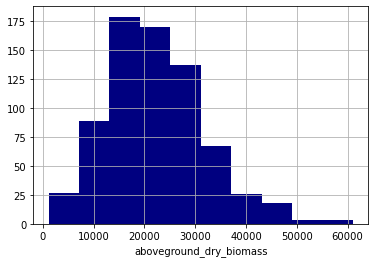

In [26]:
# plot_hist(adb_0, 'mean', 'trait')

In [27]:
# check_for_nulls_duplicates(adb_0)

Sum of null values:
plot              0
scientificname    0
genotype          0
treatment         0
date              0
trait             0
method            0
mean              0
checked           0
author            0
season            0
method_type       0
dtype: int64
-----
Value counts for duplicates:
False    719
dtype: int64


In [28]:
# check_unique_values(adb_0)

In [29]:
adb_1 = extract_range_column_values(adb_0, 'plot')
# print(adb_1.shape)
# adb_1.sample(n=3)

(719, 14)


,plot,scientificname,genotype,treatment,date,trait,method,mean,checked,author,season,method_type,range,column
716,MAC Field Scanner Season 4 Range 4 Column 3,Sorghum bicolor,PI646251,MAC Season 4: BAP water-deficit stress Aug 15-30,2017-09-10,aboveground_dry_biomass,Whole above ground biomass at harvest,6660,0,"Newcomb, Maria",Season 4,manual,4,3
365,MAC Field Scanner Season 4 Range 6 Column 4,Sorghum bicolor,PI329286,MAC Season 4: BAP water-deficit stress Aug 15-30,2017-09-10,aboveground_dry_biomass,Whole above ground biomass at harvest,17300,0,"Newcomb, Maria",Season 4,manual,6,4
304,MAC Field Scanner Season 4 Range 18 Column 11,Sorghum bicolor,PI641862,MAC Season 4: BAP water-deficit stress Aug 15-30,2017-09-14,aboveground_dry_biomass,Whole above ground biomass at harvest,24030,0,"Newcomb, Maria",Season 4,manual,18,11


In [30]:
adb_2 = convert_datetime_column(adb_1, 'date')
# print(adb_2.shape)
# adb_2.head()

(719, 14)


,plot,scientificname,genotype,treatment,trait,method,mean,checked,author,season,method_type,range,column,date
0,MAC Field Scanner Season 4 Range 50 Column 4,Sorghum bicolor,PI535794,MAC Season 4: BAP water-deficit stress Aug 15-30,aboveground_dry_biomass,Whole above ground biomass at harvest,11470,0,"Newcomb, Maria",Season 4,manual,50,4,2017-09-10
1,MAC Field Scanner Season 4 Range 51 Column 4,Sorghum bicolor,PI586435,MAC Season 4: BAP water-deficit stress Aug 15-30,aboveground_dry_biomass,Whole above ground biomass at harvest,22790,0,"Newcomb, Maria",Season 4,manual,51,4,2017-09-10
2,MAC Field Scanner Season 4 Range 10 Column 5,Sorghum bicolor,PI641821,MAC Season 4: BAP water-deficit stress Aug 1-14,aboveground_dry_biomass,Whole above ground biomass at harvest,43730,0,"Newcomb, Maria",Season 4,manual,10,5,2017-09-11
3,MAC Field Scanner Season 4 Range 13 Column 5,Sorghum bicolor,PI586443,MAC Season 4: BAP water-deficit stress Aug 1-14,aboveground_dry_biomass,Whole above ground biomass at harvest,8775,0,"Newcomb, Maria",Season 4,manual,13,5,2017-09-11
4,MAC Field Scanner Season 4 Range 14 Column 5,Sorghum bicolor,PI562997,MAC Season 4: BAP water-deficit stress Aug 1-14,aboveground_dry_biomass,Whole above ground biomass at harvest,32520,0,"Newcomb, Maria",Season 4,manual,14,5,2017-09-11


In [32]:
adb_3 = rename_value_column(adb_2, 'mean', 'trait')
# print(adb_3.shape)
# adb_3.tail()

(719, 13)


,plot,scientificname,genotype,treatment,method,aboveground_dry_biomass,checked,author,season,method_type,range,column,date
714,MAC Field Scanner Season 4 Range 39 Column 3,Sorghum bicolor,PI651496,MAC Season 4: BAP water-deficit stress Aug 15-30,Whole above ground biomass at harvest,17910,0,"Newcomb, Maria",Season 4,manual,39,3,2017-09-10
715,MAC Field Scanner Season 4 Range 40 Column 3,Sorghum bicolor,PI330858,MAC Season 4: BAP water-deficit stress Aug 15-30,Whole above ground biomass at harvest,26110,0,"Newcomb, Maria",Season 4,manual,40,3,2017-09-10
716,MAC Field Scanner Season 4 Range 4 Column 3,Sorghum bicolor,PI646251,MAC Season 4: BAP water-deficit stress Aug 15-30,Whole above ground biomass at harvest,6660,0,"Newcomb, Maria",Season 4,manual,4,3,2017-09-10
717,MAC Field Scanner Season 4 Range 13 Column 4,Sorghum bicolor,PI569244,MAC Season 4: BAP water-deficit stress Aug 15-30,Whole above ground biomass at harvest,26630,0,"Newcomb, Maria",Season 4,manual,13,4,2017-09-10
718,MAC Field Scanner Season 4 Range 5 Column 4,Sorghum bicolor,PI525049,MAC Season 4: BAP water-deficit stress Aug 15-30,Whole above ground biomass at harvest,26000,0,"Newcomb, Maria",Season 4,manual,5,4,2017-09-10


In [33]:
cols_to_drop = ['checked', 'author', 'season']

adb_4 = adb_3.drop(labels=cols_to_drop, axis=1)
# print(adb_4.shape)
# adb_4.head(3)

(719, 10)


,plot,scientificname,genotype,treatment,method,aboveground_dry_biomass,method_type,range,column,date
0,MAC Field Scanner Season 4 Range 50 Column 4,Sorghum bicolor,PI535794,MAC Season 4: BAP water-deficit stress Aug 15-30,Whole above ground biomass at harvest,11470,manual,50,4,2017-09-10
1,MAC Field Scanner Season 4 Range 51 Column 4,Sorghum bicolor,PI586435,MAC Season 4: BAP water-deficit stress Aug 15-30,Whole above ground biomass at harvest,22790,manual,51,4,2017-09-10
2,MAC Field Scanner Season 4 Range 10 Column 5,Sorghum bicolor,PI641821,MAC Season 4: BAP water-deficit stress Aug 1-14,Whole above ground biomass at harvest,43730,manual,10,5,2017-09-11


In [34]:
adb_5 = add_season_4_blocking_height(adb_4, 'range')
# print(adb_5.shape)
# adb_5.sample(n=3)

(719, 11)


,plot,scientificname,genotype,treatment,method,aboveground_dry_biomass,method_type,range,column,date,blocking_height
1,MAC Field Scanner Season 4 Range 51 Column 4,Sorghum bicolor,PI586435,MAC Season 4: BAP water-deficit stress Aug 15-30,Whole above ground biomass at harvest,22790,manual,51,4,2017-09-10,medium
172,MAC Field Scanner Season 4 Range 9 Column 2,Sorghum bicolor,PI569416,MAC Season 4: BAP water-deficit stress Aug 15-30,Whole above ground biomass at harvest,9052,manual,9,2,2017-09-10,tall
166,MAC Field Scanner Season 4 Range 18 Column 15,Sorghum bicolor,PI218112,MAC Season 4: BAP water-deficit stress Aug 1-14,Whole above ground biomass at harvest,14890,manual,18,15,2017-09-15,medium


##### Add units (kg/ha) column to aboveground dry biomass dataset

In [35]:
adb_6 = adb_5.copy()
adb_6['units'] = 'kg/ha'

# print(adb_6.shape)
# adb_6.tail(3)

(719, 12)


,plot,scientificname,genotype,treatment,method,aboveground_dry_biomass,method_type,range,column,date,blocking_height,units
716,MAC Field Scanner Season 4 Range 4 Column 3,Sorghum bicolor,PI646251,MAC Season 4: BAP water-deficit stress Aug 15-30,Whole above ground biomass at harvest,6660,manual,4,3,2017-09-10,tall,kg/ha
717,MAC Field Scanner Season 4 Range 13 Column 4,Sorghum bicolor,PI569244,MAC Season 4: BAP water-deficit stress Aug 15-30,Whole above ground biomass at harvest,26630,manual,13,4,2017-09-10,tall,kg/ha
718,MAC Field Scanner Season 4 Range 5 Column 4,Sorghum bicolor,PI525049,MAC Season 4: BAP water-deficit stress Aug 15-30,Whole above ground biomass at harvest,26000,manual,5,4,2017-09-10,tall,kg/ha


In [36]:
new_col_order = ['date', 'plot', 'range', 'column', 'scientificname', 'genotype', 'treatment', 'blocking_height', 
                 'method', 'aboveground_dry_biomass', 'units', 'method_type']

adb_7 = reorder_columns(adb_6, new_col_order)
# print(adb_7.shape)
# adb_7.head(3)

(719, 12)


,date,plot,range,column,scientificname,genotype,treatment,blocking_height,method,aboveground_dry_biomass,units,method_type
0,2017-09-10,MAC Field Scanner Season 4 Range 50 Column 4,50,4,Sorghum bicolor,PI535794,MAC Season 4: BAP water-deficit stress Aug 15-30,short,Whole above ground biomass at harvest,11470,kg/ha,manual
1,2017-09-10,MAC Field Scanner Season 4 Range 51 Column 4,51,4,Sorghum bicolor,PI586435,MAC Season 4: BAP water-deficit stress Aug 15-30,medium,Whole above ground biomass at harvest,22790,kg/ha,manual
2,2017-09-11,MAC Field Scanner Season 4 Range 10 Column 5,10,5,Sorghum bicolor,PI641821,MAC Season 4: BAP water-deficit stress Aug 1-14,medium,Whole above ground biomass at harvest,43730,kg/ha,manual


#### B. Canopy Height - Sensor

In [39]:
canopy_height_sensor_s4_url = 'https://de.cyverse.org/dl/d/CD0093FE-7576-4BDC-B309-51C592A528DF/season_4_canopy_height_sensor.csv'
canopy_height_sensor_s4_input_filename = 'canopy_height_sensor_s4.csv'

In [40]:
download_csv(canopy_height_sensor_s4_url, folder_name=folder_name, file_name=canopy_height_sensor_s4_input_filename)

In [41]:
ch_0 = read_in_csv(folder_name=folder_name, file_name=canopy_height_sensor_s4_input_filename)
# print(ch_0.shape)
# ch_0.head()

(40173, 12)


,plot,scientificname,genotype,treatment,date,trait,method,mean,checked,author,season,method_type
0,MAC Field Scanner Season 4 Range 11 Column 4,Sorghum bicolor,PI180348,MAC Season 4: BAP water-deficit stress Aug 15-30,2017-05-01,canopy_height,3D scanner to 98th quantile height,12,0,"Zongyang, Li",Season 4,sensor
1,MAC Field Scanner Season 4 Range 11 Column 4,Sorghum bicolor,PI180348,MAC Season 4: BAP water-deficit stress Aug 15-30,2017-05-03,canopy_height,3D scanner to 98th quantile height,12,0,"Zongyang, Li",Season 4,sensor
2,MAC Field Scanner Season 4 Range 11 Column 4,Sorghum bicolor,PI180348,MAC Season 4: BAP water-deficit stress Aug 15-30,2017-05-04,canopy_height,3D scanner to 98th quantile height,11,0,"Zongyang, Li",Season 4,sensor
3,MAC Field Scanner Season 4 Range 11 Column 4,Sorghum bicolor,PI180348,MAC Season 4: BAP water-deficit stress Aug 15-30,2017-05-05,canopy_height,3D scanner to 98th quantile height,12,0,"Zongyang, Li",Season 4,sensor
4,MAC Field Scanner Season 4 Range 11 Column 4,Sorghum bicolor,PI180348,MAC Season 4: BAP water-deficit stress Aug 15-30,2017-05-06,canopy_height,3D scanner to 98th quantile height,12,0,"Zongyang, Li",Season 4,sensor


In [42]:
# check_unique_values(ch_0)

In [43]:
# check_for_nulls_duplicates(ch_0)

Sum of null values:
plot              0
scientificname    0
genotype          0
treatment         0
date              0
trait             0
method            0
mean              0
checked           0
author            0
season            0
method_type       0
dtype: int64
-----
Value counts for duplicates:
False    39511
True       662
dtype: int64


#### Drop duplicates

In [44]:
ch_1 = ch_0.drop_duplicates(ignore_index=True)
# print(ch_1.shape)
# check_for_nulls_duplicates(ch_1)

(39511, 12)
Sum of null values:
plot              0
scientificname    0
genotype          0
treatment         0
date              0
trait             0
method            0
mean              0
checked           0
author            0
season            0
method_type       0
dtype: int64
-----
Value counts for duplicates:
False    39511
dtype: int64


In [72]:
check_for_subplots(ch_1, 'plot')

'No subplot designations'

In [46]:
ch_2 = extract_range_column_values(ch_1, 'plot')
# print(ch_2.shape)
# ch_2.sample(n=3)

(39511, 14)


,plot,scientificname,genotype,treatment,date,trait,method,mean,checked,author,season,method_type,range,column
13462,MAC Field Scanner Season 4 Range 52 Column 14,Sorghum bicolor,PI329618,MAC Season 4: BAP water-deficit stress Aug 1-14,2017-05-15,canopy_height,3D scanner to 98th quantile height,18,0,"Zongyang, Li",Season 4,sensor,52,14
19145,MAC Field Scanner Season 4 Range 16 Column 4,Sorghum bicolor,PI562970,MAC Season 4: BAP water-deficit stress Aug 15-30,2017-05-05,canopy_height,3D scanner to 98th quantile height,11,0,"Zongyang, Li",Season 4,sensor,16,4
33961,MAC Field Scanner Season 4 Range 24 Column 14,Sorghum bicolor,PI157804,MAC Season 4: BAP water-deficit stress Aug 1-14,2017-06-20,canopy_height,3D scanner to 98th quantile height,254,0,"Zongyang, Li",Season 4,sensor,24,14


In [47]:
ch_3 = convert_datetime_column(ch_2, 'date')
# print(ch_3.shape)
# ch_3.dtypes

(39511, 14)


In [48]:
ch_4 = rename_value_column(ch_3, 'mean', 'trait')
# print(ch_4.shape)
# ch_4.tail(3)

In [49]:
ch_5 = add_season_4_blocking_height(ch_4, 'range')
# ch_5.sample(n=3)

In [50]:
ch_6 = ch_5.drop(labels=['checked', 'author', 'season'], axis=1)
# print(ch_6.shape)

#### Add units column
- cm

In [51]:
ch_7 = ch_6.copy()
ch_7['units'] = 'cm'
# print(ch_7.shape)
# ch_7.head(3)

(39511, 12)


,plot,scientificname,genotype,treatment,method,canopy_height,method_type,range,column,date,blocking_height,units
0,MAC Field Scanner Season 4 Range 11 Column 4,Sorghum bicolor,PI180348,MAC Season 4: BAP water-deficit stress Aug 15-30,3D scanner to 98th quantile height,12,sensor,11,4,2017-05-01,short,cm
1,MAC Field Scanner Season 4 Range 11 Column 4,Sorghum bicolor,PI180348,MAC Season 4: BAP water-deficit stress Aug 15-30,3D scanner to 98th quantile height,12,sensor,11,4,2017-05-03,short,cm
2,MAC Field Scanner Season 4 Range 11 Column 4,Sorghum bicolor,PI180348,MAC Season 4: BAP water-deficit stress Aug 15-30,3D scanner to 98th quantile height,11,sensor,11,4,2017-05-04,short,cm


In [52]:
new_col_order = ['date', 'plot', 'range', 'column', 'scientificname', 'genotype', 'treatment', 'blocking_height', 
                 'method', 'canopy_height', 'units', 'method_type']

ch_8 = reorder_columns(ch_7, new_col_order)
# print(ch_8.shape)
# ch_8.head(3)

#### C. Canopy Height - Manual
- using SQLite for `groupby`

In [54]:
canopy_height_manual_s4_url = 'https://de.cyverse.org/dl/d/AE10E379-BBBA-428C-AAC6-7B27296316B7/season_4_canopy_height_manual.csv'
canopy_height_manual_s4_input_filename = 'canopy_height_manual_s4.csv'

In [55]:
download_csv(canopy_height_manual_s4_url, folder_name=folder_name, file_name=canopy_height_manual_s4_input_filename)

In [56]:
chm_0 = read_in_csv(folder_name=folder_name, file_name=canopy_height_manual_s4_input_filename)
# print(ch_0.shape)
# ch_0.head()

In [57]:
# check_for_nulls_duplicates(chm_0)

Sum of null values:
plot              0
scientificname    0
genotype          0
treatment         0
date              0
trait             0
method            0
mean              0
checked           0
author            0
season            0
method_type       0
dtype: int64
-----
Value counts for duplicates:
False    6501
dtype: int64


In [ ]:
# check_unique_values(chm_0)

In [58]:
chm_1 = extract_range_column_values(chm_0, 'plot')
# print(chm_1.shape)
# chm_1.sample(n=3)

(6501, 14)


In [59]:
chm_2 = convert_datetime_column(chm_1, 'date')
# print(chm_2.shape)
# chm_2.head()

#### Identify and Remove Subplot Designations

In [74]:
# check_for_subplots(chm_2, 'plot')
# incorrectly returns 'No subplot designations'

In [75]:
chm_2.loc[(chm_2['plot'].str.endswith(' W')) | (chm_2['plot'].str.endswith(' E'))].shape

(5803, 14)

In [76]:
chm_3 = strip_subplots(chm_2, 'plot', 'plot')
# print(chm_3.shape)
# chm_3.sample(n=3)

(6501, 14)


,scientificname,genotype,treatment,trait,method,mean,checked,author,season,method_type,range,column,date,plot
1921,Sorghum bicolor,PI653617,MAC Season 4: BAP water-deficit stress Aug 1-14,canopy_height,Manual canopy height,250,0,"Newcomb, Maria",Season 4,manual,5,14,2017-06-19,MAC Field Scanner Season 4 Range 5 Column 14
2588,Sorghum bicolor,PI570085,MAC Season 4: BAP water-deficit stress Aug 1-14,canopy_height,Manual canopy height,89,0,"Newcomb, Maria",Season 4,manual,48,14,2017-06-04,MAC Field Scanner Season 4 Range 48 Column 14
564,Sorghum bicolor,PI297155,MAC Season 4: BAP water-deficit stress Aug 15-30,canopy_height,Manual canopy height,117,0,"Newcomb, Maria",Season 4,manual,10,4,2017-06-14,MAC Field Scanner Season 4 Range 10 Column 4


In [78]:
# check_for_subplots(chm_3, 'plot')

In [79]:
# check for plot/date/mean/treatment duplicates

# chm_3.duplicated(subset=['plot', 'date', 'mean', 'treatment']).value_counts()

False    5789
True      712
dtype: int64

In [80]:
# Drop Duplicates

chm_4 = chm_3.drop_duplicates(ignore_index=True, subset=['plot', 'genotype', 'treatment', 'mean', 'range', 'column',
                                                        'date'])

# print(chm_4.shape)
# chm_4.duplicated().value_counts()

(5789, 14)


False    5789
dtype: int64

In [86]:
chm_5 = add_season_4_blocking_height(chm_4, 'range')
# print(chm_5.shape)
# chm_5.sample(n=3)

(5789, 15)


,scientificname,genotype,treatment,trait,method,mean,checked,author,season,method_type,range,column,date,plot,blocking_height
3670,Sorghum bicolor,PI562990,MAC Season 4: BAP water-deficit stress Aug 15-30,canopy_height,Manual canopy height,96,0,"Newcomb, Maria",Season 4,manual,28,3,2017-06-04,MAC Field Scanner Season 4 Range 28 Column 3,tall
1894,Sorghum bicolor,PI586443,MAC Season 4: BAP water-deficit stress Aug 1-14,canopy_height,Manual canopy height,264,0,"Newcomb, Maria",Season 4,manual,13,5,2017-07-05,MAC Field Scanner Season 4 Range 13 Column 5,tall
935,Sorghum bicolor,PI152771,MAC Season 4: BAP water-deficit stress Aug 1-14,canopy_height,Manual canopy height,57,0,"Newcomb, Maria",Season 4,manual,3,12,2017-05-29,MAC Field Scanner Season 4 Range 3 Column 12,tall


#### Use sqlite database to group by `plot`, `date`, and `mean` 
- rename `mean` to `canopy_height_cm`
- can also drop and reorder columns at this time

In [88]:
conn = sqlite3.connect('data/canopy_heights_manual_season_4.sqlite')
cursor = conn.cursor()
print("Opened database successfully")

Opened database successfully


In [89]:
# comment next line out if db has already been created
chm_5.to_sql('canopy_heights_manual_season_4.sqlite', conn)

In [90]:
chm_6 = pd.read_sql_query("""
                            SELECT date, plot, range, column, scientificname, genotype, treatment, blocking_height,
                            method, ROUND(AVG([mean]), 2) AS canopy_height_cm, method_type
                            FROM 'canopy_heights_manual_season_4.sqlite'
                            GROUP BY plot, date,[mean]
                            ORDER BY date ASC;
                            """, conn)

print(chm_6.shape)
chm_6.head(3)

(5789, 11)


,date,plot,range,column,scientificname,genotype,treatment,blocking_height,method,canopy_height_cm,method_type
0,2017-05-24 00:00:00,MAC Field Scanner Season 4 Range 10 Column 11,10,11,Sorghum bicolor,PI195754,MAC Season 4: BAP water-deficit stress Aug 15-30,medium,Manual canopy height,47.0,manual
1,2017-05-24 00:00:00,MAC Field Scanner Season 4 Range 10 Column 12,10,12,Sorghum bicolor,PI329501,MAC Season 4: BAP water-deficit stress Aug 1-14,medium,Manual canopy height,26.0,manual
2,2017-05-24 00:00:00,MAC Field Scanner Season 4 Range 10 Column 12,10,12,Sorghum bicolor,PI329501,MAC Season 4: BAP water-deficit stress Aug 1-14,medium,Manual canopy height,31.0,manual


#### D. Days & GDD to Flowering

In [92]:
flowering_time_s4_url = 'https://de.cyverse.org/dl/d/106ECC85-52DE-4769-8F3D-CC747C82ECE2/season_4_flowering_time_manual.csv'
flowering_time_s4_input_filename = 'flowering_time_s4.csv'

In [93]:
download_csv(flowering_time_s4_url, folder_name=folder_name, file_name=flowering_time_s4_input_filename)

In [94]:
fl_0 = read_in_csv(folder_name=folder_name, file_name=flowering_time_s4_input_filename)

#### Read in processed weather dataset for season 4

In [95]:
weather_s4_url = 'https://de.cyverse.org/dl/d/6D959379-0442-41FE-8BEE-890866ACF037/mac_season_4_weather.csv'
weather_s4_input_filename = 'weather_s4.csv'

In [96]:
download_csv(weather_s4_url, folder_name=folder_name, file_name=weather_s4_input_filename)

In [97]:
weather_0 = read_in_csv(folder_name=folder_name, file_name=weather_s4_input_filename)
# print(weather_0.shape)
# weather_0.head()

(150, 14)


,date,day_of_year,temp_min,temp_max,temp_mean,gdd,rh_min,rh_max,rh_mean,vpd_mean,precip,precip_cumulative,first_water_deficit_treatment,second_water_deficit_treatment
0,2017-04-20,110,14.1,33.3,23.5,14.0,5.1,45.0,18.2,2.63,0.0,0.0,False,False
1,2017-04-21,111,11.1,34.4,24.0,26.0,5.5,46.5,17.2,2.82,0.0,0.0,False,False
2,2017-04-22,112,14.5,35.5,25.0,41.0,6.4,32.5,15.6,2.95,0.0,0.0,False,False
3,2017-04-23,113,12.6,37.0,26.5,56.0,6.8,48.0,17.5,3.25,0.0,0.0,False,False
4,2017-04-24,114,14.9,33.7,25.7,71.0,8.3,33.1,17.5,2.89,0.0,0.0,False,False


Text(0.5, 0, 'flowering_time')

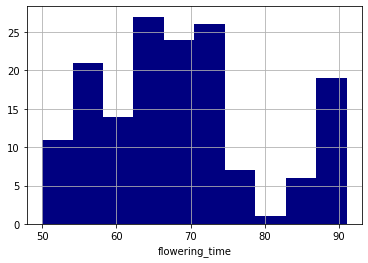

In [98]:
# plot_hist(fl_0, 'mean', 'trait')

In [99]:
# check_for_nulls_duplicates(fl_0)

Sum of null values:
plot              0
scientificname    0
genotype          0
treatment         0
date              0
trait             0
method            0
mean              0
checked           0
author            0
season            0
method_type       0
dtype: int64
-----
Value counts for duplicates:
False    156
dtype: int64


In [100]:
# check_for_subplots(fl_0, 'plot')

'No subplot designations'

In [ ]:
# check_unique_values(fl_0)

#### Add planting date 2017-04-20

In [101]:
day_of_planting = datetime.date(2017,4,20)
flower_df_1 = fl_0.copy()

flower_df_1['date_of_planting'] = day_of_planting
# print(flower_df_1.shape)
# flower_df_1.head(3)

(156, 13)


,plot,scientificname,genotype,treatment,date,trait,method,mean,checked,author,season,method_type,date_of_planting
0,MAC Field Scanner Season 4 Range 51 Column 4,Sorghum bicolor,PI586435,MAC Season 4: BAP water-deficit stress Aug 15-30,2017-07-20,flowering_time,Visual classification of sorghum growth stages...,70,0,"Newcomb, Maria",Season 4,manual,2017-04-20
1,MAC Field Scanner Season 4 Range 16 Column 7,Sorghum bicolor,PI152651,MAC Season 4: BAP water-deficit stress Aug 1-14,2017-07-20,flowering_time,Visual classification of sorghum growth stages...,50,0,"Newcomb, Maria",Season 4,manual,2017-04-20
2,MAC Field Scanner Season 4 Range 50 Column 7,Sorghum bicolor,PI154988,MAC Season 4: BAP water-deficit stress Aug 1-14,2017-07-20,flowering_time,Visual classification of sorghum growth stages...,76,0,"Newcomb, Maria",Season 4,manual,2017-04-20


#### Create datetime with days to flowering (`mean`)

In [102]:
timedelta = pd.Series([pd.Timedelta(days=i) for i in flower_df_1['mean'].values])
dates_of_flowering = []

for td in timedelta:
    
    date_of_flowering = day_of_planting + td
    dates_of_flowering.append(date_of_flowering)
    
# print(flower_df_1.shape[0])
# print(len(dates_of_flowering))

156
156


In [103]:
flower_df_2 = flower_df_1.copy()
flower_df_2['date_of_flowering'] = dates_of_flowering
# print(flower_df_2.shape)
# flower_df_2.head(3)

(156, 14)


,plot,scientificname,genotype,treatment,date,trait,method,mean,checked,author,season,method_type,date_of_planting,date_of_flowering
0,MAC Field Scanner Season 4 Range 51 Column 4,Sorghum bicolor,PI586435,MAC Season 4: BAP water-deficit stress Aug 15-30,2017-07-20,flowering_time,Visual classification of sorghum growth stages...,70,0,"Newcomb, Maria",Season 4,manual,2017-04-20,2017-06-29
1,MAC Field Scanner Season 4 Range 16 Column 7,Sorghum bicolor,PI152651,MAC Season 4: BAP water-deficit stress Aug 1-14,2017-07-20,flowering_time,Visual classification of sorghum growth stages...,50,0,"Newcomb, Maria",Season 4,manual,2017-04-20,2017-06-09
2,MAC Field Scanner Season 4 Range 50 Column 7,Sorghum bicolor,PI154988,MAC Season 4: BAP water-deficit stress Aug 1-14,2017-07-20,flowering_time,Visual classification of sorghum growth stages...,76,0,"Newcomb, Maria",Season 4,manual,2017-04-20,2017-07-05


#### Add GDD to flowering dataframe

In [104]:
# slice weather df for date and cumulative gdd values only

season_4_gdd = weather_0[['date', 'gdd']]
print(season_4_gdd.shape)
season_4_gdd.head(3)

(150, 2)


,date,gdd
0,2017-04-20,14.0
1,2017-04-21,26.0
2,2017-04-22,41.0


In [106]:
flower_df_3 = flower_df_2.copy()
flower_df_3.date_of_flowering = pd.to_datetime(flower_df_3.date_of_flowering)
# flower_df_3.dtypes

plot                         object
scientificname               object
genotype                     object
treatment                    object
date                         object
trait                        object
method                       object
mean                          int64
checked                       int64
author                       object
season                       object
method_type                  object
date_of_planting             object
date_of_flowering    datetime64[ns]
dtype: object

In [107]:
season_4_gdd_1 = season_4_gdd.copy()
season_4_gdd_1['date'] = pd.to_datetime(season_4_gdd_1['date'])
# season_4_gdd_1.dtypes

date    datetime64[ns]
gdd            float64
dtype: object

In [108]:
flower_df_4 = flower_df_3.merge(season_4_gdd_1, how='left', left_on='date_of_flowering', right_on='date')
# print(flower_df_4.shape)
# flower_df_4.head(3)

(156, 16)


,plot,scientificname,genotype,treatment,date_x,trait,method,mean,checked,author,season,method_type,date_of_planting,date_of_flowering,date_y,gdd
0,MAC Field Scanner Season 4 Range 51 Column 4,Sorghum bicolor,PI586435,MAC Season 4: BAP water-deficit stress Aug 15-30,2017-07-20,flowering_time,Visual classification of sorghum growth stages...,70,0,"Newcomb, Maria",Season 4,manual,2017-04-20,2017-06-29,2017-06-29,1250.0
1,MAC Field Scanner Season 4 Range 16 Column 7,Sorghum bicolor,PI152651,MAC Season 4: BAP water-deficit stress Aug 1-14,2017-07-20,flowering_time,Visual classification of sorghum growth stages...,50,0,"Newcomb, Maria",Season 4,manual,2017-04-20,2017-06-09,2017-06-09,799.0
2,MAC Field Scanner Season 4 Range 50 Column 7,Sorghum bicolor,PI154988,MAC Season 4: BAP water-deficit stress Aug 1-14,2017-07-20,flowering_time,Visual classification of sorghum growth stages...,76,0,"Newcomb, Maria",Season 4,manual,2017-04-20,2017-07-05,2017-07-05,1394.0


In [109]:
flower_df_5 = extract_range_column_values(flower_df_4, 'plot')
flower_df_6 = add_season_4_blocking_height(flower_df_5, 'range')

print(flower_df_6.shape)
# flower_df_6.tail(3)

(156, 19)


In [110]:
flower_df_7 = rename_value_column(flower_df_6, 'mean', 'trait')
# flower_df_7.sample(n=3)

,plot,scientificname,genotype,treatment,date_x,method,flowering_time,checked,author,season,method_type,date_of_planting,date_of_flowering,date_y,gdd,range,column,blocking_height
39,MAC Field Scanner Season 4 Range 50 Column 8,Sorghum bicolor,PI593916,MAC Season 4: BAP water-deficit stress Aug 1-14,2017-07-20,Visual classification of sorghum growth stages...,63,0,"Newcomb, Maria",Season 4,manual,2017-04-20,2017-06-22,2017-06-22,1076.0,50,8,short
52,MAC Field Scanner Season 4 Range 34 Column 4,Sorghum bicolor,PI22913,MAC Season 4: BAP water-deficit stress Aug 15-30,2017-07-20,Visual classification of sorghum growth stages...,64,0,"Newcomb, Maria",Season 4,manual,2017-04-20,2017-06-23,2017-06-23,1100.0,34,4,tall
124,MAC Field Scanner Season 4 Range 24 Column 12,Sorghum bicolor,PI197542,MAC Season 4: BAP water-deficit stress Aug 1-14,2017-07-20,Visual classification of sorghum growth stages...,50,0,"Newcomb, Maria",Season 4,manual,2017-04-20,2017-06-09,2017-06-09,799.0,24,12,medium


In [111]:
flower_df_8 = flower_df_7.rename({'flowering_time': 'days_to_flowering', 'gdd': 'gdd_to_flowering'}, axis=1)
# flower_df_8.head(2)

In [112]:
cols_to_drop = ['date_x', 'checked', 'author', 'season', 'date_of_planting', 'date_y']

flower_df_9 = flower_df_8.drop(labels=cols_to_drop, axis=1)
print(flower_df_9.shape)
# flower_df_9.sample(n=3)

(156, 12)


In [113]:
new_col_order = ['plot', 'range', 'column', 'scientificname', 'genotype', 'treatment', 'blocking_height', 
                 'method', 'date_of_flowering', 'days_to_flowering', 'gdd_to_flowering', 'method_type']

flower_df_10 = reorder_columns(flower_df_9, new_col_order)
# print(flower_df_10.shape)
# flower_df_10.head(3)

(156, 12)


,plot,range,column,scientificname,genotype,treatment,blocking_height,method,date_of_flowering,days_to_flowering,gdd_to_flowering,method_type
0,MAC Field Scanner Season 4 Range 51 Column 4,51,4,Sorghum bicolor,PI586435,MAC Season 4: BAP water-deficit stress Aug 15-30,medium,Visual classification of sorghum growth stages...,2017-06-29,70,1250.0,manual
1,MAC Field Scanner Season 4 Range 16 Column 7,16,7,Sorghum bicolor,PI152651,MAC Season 4: BAP water-deficit stress Aug 1-14,tall,Visual classification of sorghum growth stages...,2017-06-09,50,799.0,manual
2,MAC Field Scanner Season 4 Range 50 Column 7,50,7,Sorghum bicolor,PI154988,MAC Season 4: BAP water-deficit stress Aug 1-14,short,Visual classification of sorghum growth stages...,2017-07-05,76,1394.0,manual


#### E. Days & GDD to Flag Leaf Emergence

In [114]:
flag_leaf_s4_url = 'https://de.cyverse.org/dl/d/DFE10710-4367-4974-91D2-4C6E10DE89D6/season_4_flag_leaf_emergence_time_manual.csv'
flag_leaf_s4_input_filename = 'flag_leaf_s4.csv'

In [115]:
download_csv(flag_leaf_s4_url, folder_name=folder_name, file_name=flag_leaf_s4_input_filename)

In [116]:
fle_0 = read_in_csv(folder_name=folder_name, file_name=flag_leaf_s4_input_filename)

In [117]:
# print(weather_0.shape)
# weather_0.tail()

(150, 14)


,date,day_of_year,temp_min,temp_max,temp_mean,gdd,rh_min,rh_max,rh_mean,vpd_mean,precip,precip_cumulative,first_water_deficit_treatment,second_water_deficit_treatment
145,2017-09-12,255,24.2,42.8,34.0,2955.0,13.3,58.0,28.1,4.14,0.0,50.79,False,False
146,2017-09-13,256,24.3,41.3,33.9,2978.0,14.3,54.1,27.3,4.08,0.0,50.79,False,False
147,2017-09-14,257,22.8,39.5,31.4,2999.0,17.8,50.6,32.9,3.29,0.0,50.79,False,False
148,2017-09-15,258,21.4,36.2,28.5,3018.0,14.2,63.7,33.7,2.82,0.0,50.79,False,False
149,2017-09-16,259,18.2,36.3,27.6,3035.0,16.7,51.4,29.9,2.80,0.0,50.79,False,False


Text(0.5, 0, 'flag_leaf_emergence_time')

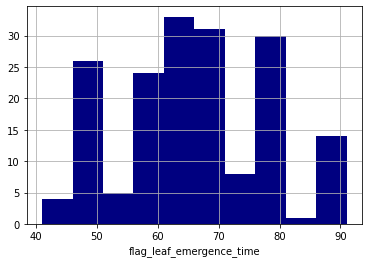

In [118]:
# plot_hist(fle_0, 'mean', 'trait')

In [119]:
# check_for_nulls_duplicates(fle_0)

Sum of null values:
plot              0
scientificname    0
genotype          0
treatment         0
date              0
trait             0
method            0
mean              0
checked           0
author            0
season            0
method_type       0
dtype: int64
-----
Value counts for duplicates:
False    176
dtype: int64


In [120]:
# check_for_subplots(fle_0, 'plot')

'No subplot designations'

In [ ]:
# check_unique_values(fle_0)

#### Add planting date 2017-04-20

In [121]:
day_of_planting = datetime.date(2017,4,20)
fle_df_1 = fle_0.copy()

fle_df_1['date_of_planting'] = day_of_planting
# print(fle_df_1.shape)
# fle_df_1.head(3)

(176, 13)


,plot,scientificname,genotype,treatment,date,trait,method,mean,checked,author,season,method_type,date_of_planting
0,MAC Field Scanner Season 4 Range 51 Column 4,Sorghum bicolor,PI586435,MAC Season 4: BAP water-deficit stress Aug 15-30,2017-07-20,flag_leaf_emergence_time,Visual classification of sorghum growth stages...,62,0,"Newcomb, Maria",Season 4,manual,2017-04-20
1,MAC Field Scanner Season 4 Range 46 Column 6,Sorghum bicolor,PI542718,MAC Season 4: BAP water-deficit stress Aug 1-14,2017-07-20,flag_leaf_emergence_time,Visual classification of sorghum growth stages...,50,0,"Newcomb, Maria",Season 4,manual,2017-04-20
2,MAC Field Scanner Season 4 Range 16 Column 7,Sorghum bicolor,PI152651,MAC Season 4: BAP water-deficit stress Aug 1-14,2017-07-20,flag_leaf_emergence_time,Visual classification of sorghum growth stages...,41,0,"Newcomb, Maria",Season 4,manual,2017-04-20


#### Create timedelta using days to flag leaf emergence (`mean`)

In [122]:
timedelta = pd.Series([pd.Timedelta(days=i) for i in fle_df_1['mean'].values])
dates_of_flag_leaf_emergence = []

for td in timedelta:
    
    date_of_flag_leaf_emergence = day_of_planting + td
    dates_of_flag_leaf_emergence.append(date_of_flag_leaf_emergence)
    
# print(fle_df_1.shape[0])
# print(len(dates_of_flag_leaf_emergence))

176
176


In [123]:
fle_df_2 = fle_df_1.copy()
fle_df_2['date_of_flag_leaf_emergence'] = dates_of_flag_leaf_emergence
# print(fle_df_2.shape)
# fle_df_2.head(3)

(176, 14)


#### Add GDD values to flag leaf emergence dataframe

In [124]:
# slice weather df for date and cumulative gdd values only

season_4_gdd = weather_0[['date', 'gdd']]
# print(season_4_gdd.shape)
# season_4_gdd.head(3)

(150, 2)


,date,gdd
0,2017-04-20,14.0
1,2017-04-21,26.0
2,2017-04-22,41.0


In [125]:
fle_df_3 = fle_df_2.copy()
fle_df_3.date_of_flag_leaf_emergence = pd.to_datetime(fle_df_3.date_of_flag_leaf_emergence)
# fle_df_3.dtypes

In [126]:
season_4_gdd_1 = season_4_gdd.copy()
season_4_gdd_1['date'] = pd.to_datetime(season_4_gdd_1['date'])
# season_4_gdd_1.dtypes

date    datetime64[ns]
gdd            float64
dtype: object

In [127]:
fle_df_4 = fle_df_3.merge(season_4_gdd_1, how='left', left_on='date_of_flag_leaf_emergence', right_on='date')
# print(fle_df_4.shape)
# fle_df_4.head(3)

(176, 16)


,plot,scientificname,genotype,treatment,date_x,trait,method,mean,checked,author,season,method_type,date_of_planting,date_of_flag_leaf_emergence,date_y,gdd
0,MAC Field Scanner Season 4 Range 51 Column 4,Sorghum bicolor,PI586435,MAC Season 4: BAP water-deficit stress Aug 15-30,2017-07-20,flag_leaf_emergence_time,Visual classification of sorghum growth stages...,62,0,"Newcomb, Maria",Season 4,manual,2017-04-20,2017-06-21,2017-06-21,1050.0
1,MAC Field Scanner Season 4 Range 46 Column 6,Sorghum bicolor,PI542718,MAC Season 4: BAP water-deficit stress Aug 1-14,2017-07-20,flag_leaf_emergence_time,Visual classification of sorghum growth stages...,50,0,"Newcomb, Maria",Season 4,manual,2017-04-20,2017-06-09,2017-06-09,799.0
2,MAC Field Scanner Season 4 Range 16 Column 7,Sorghum bicolor,PI152651,MAC Season 4: BAP water-deficit stress Aug 1-14,2017-07-20,flag_leaf_emergence_time,Visual classification of sorghum growth stages...,41,0,"Newcomb, Maria",Season 4,manual,2017-04-20,2017-05-31,2017-05-31,608.0


In [128]:
fle_df_5 = extract_range_column_values(fle_df_4, 'plot')
fle_df_6 = add_season_4_blocking_height(fle_df_5, 'range')

# print(fle_df_6.shape)
# fle_df_6.tail(3)

In [129]:
fle_df_7 = rename_value_column(fle_df_6, 'mean', 'trait')
# fle_df_7.sample(n=3)

,plot,scientificname,genotype,treatment,date_x,method,flag_leaf_emergence_time,checked,author,season,method_type,date_of_planting,date_of_flag_leaf_emergence,date_y,gdd,range,column,blocking_height
124,MAC Field Scanner Season 4 Range 8 Column 2,Sorghum bicolor,PI176766,MAC Season 4: BAP water-deficit stress Aug 15-30,2017-07-20,Visual classification of sorghum growth stages...,62,0,"Newcomb, Maria",Season 4,manual,2017-04-20,2017-06-21,2017-06-21,1050.0,8,2,tall
5,MAC Field Scanner Season 4 Range 11 Column 9,Sorghum bicolor,PI52606,MAC Season 4: BAP water-deficit stress Aug 15-30,2017-07-20,Visual classification of sorghum growth stages...,62,0,"Newcomb, Maria",Season 4,manual,2017-04-20,2017-06-21,2017-06-21,1050.0,11,9,short
117,MAC Field Scanner Season 4 Range 20 Column 14,Sorghum bicolor,PI154988,MAC Season 4: BAP water-deficit stress Aug 1-14,2017-07-20,Visual classification of sorghum growth stages...,74,0,"Newcomb, Maria",Season 4,manual,2017-04-20,2017-07-03,2017-07-03,1343.0,20,14,short


In [130]:
fle_df_8 = fle_df_7.rename({'flag_leaf_emergence_time': 'days_to_flag_leaf_emergence', 'gdd': 'gdd_to_flag_leaf_emergence'}, axis=1)
# fle_df_8.head(2)

In [131]:
cols_to_drop = ['date_x', 'checked', 'author', 'season', 'date_of_planting', 'date_y']

fle_df_9 = fle_df_8.drop(labels=cols_to_drop, axis=1)
print(fle_df_9.shape)
# fle_df_9.sample(n=3)

(176, 12)


In [132]:
new_col_order = ['plot', 'range', 'column', 'scientificname', 'genotype', 'treatment', 'blocking_height', 
                 'method', 'date_of_flag_leaf_emergence', 'days_to_flag_leaf_emergence', 
                 'gdd_to_flag_leaf_emergence', 'method_type']

fle_df_10 = reorder_columns(fle_df_9, new_col_order)
# print(fle_df_10.shape)
# fle_df_10.head(3)

(176, 12)


,plot,range,column,scientificname,genotype,treatment,blocking_height,method,date_of_flag_leaf_emergence,days_to_flag_leaf_emergence,gdd_to_flag_leaf_emergence,method_type
0,MAC Field Scanner Season 4 Range 51 Column 4,51,4,Sorghum bicolor,PI586435,MAC Season 4: BAP water-deficit stress Aug 15-30,medium,Visual classification of sorghum growth stages...,2017-06-21,62,1050.0,manual
1,MAC Field Scanner Season 4 Range 46 Column 6,46,6,Sorghum bicolor,PI542718,MAC Season 4: BAP water-deficit stress Aug 1-14,short,Visual classification of sorghum growth stages...,2017-06-09,50,799.0,manual
2,MAC Field Scanner Season 4 Range 16 Column 7,16,7,Sorghum bicolor,PI152651,MAC Season 4: BAP water-deficit stress Aug 1-14,tall,Visual classification of sorghum growth stages...,2017-05-31,41,608.0,manual


### Save all datasets to separate csv files

In [133]:
list_of_dfs = [adb_7, ch_8, chm_6, flower_df_10, fle_df_10]
list_of_output_filenames = ['data/processed/mac_season_4_aboveground_dry_biomass.csv',
                           'data/processed/mac_season_4_canopy_height_sensor.csv',
                           'data/processed/mac_season_4_canopy_height_manual.csv',
                           'data/processed/mac_season_4_days_gdd_to_flowering.csv',
                           'data/processed/mac_season_4_days_gdd_to_flag_leaf_emergence.csv']

In [135]:
save_to_csv_without_timestamp(list_of_dfs, list_of_output_filenames)